In [1]:
import tropycal.tracks as tracks
from useful_functions import create_genesis_grid_labels
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#import skimage.measure as ms
import scipy.ndimage as nd

In [15]:
! conda install skimage -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - skimage

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [3]:
# # Time ranges for EVERYTHING desired
month_range = np.arange(6,12,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2)
Longitude=np.arange(260,360,2)

# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")

In [3]:
train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

In [93]:
num_years = len(train_labels_predropped_read["Year"]) # what are the number of years?

# sum by month, across all years
sum_canes = train_labels_predropped_read.groupby("Month").sum("Year", skipna=True).astype(float)

three_sum_canes = xr.concat([sum_canes,sum_canes,sum_canes],dim="Month").astype(float)

Gauss_SmoothAN = three_sum_canes["__xarray_dataarray_variable__"] / num_years

In [97]:
Gauss_SmoothAN.shape

(18, 40, 50)

In [ ]:
from itertools import product

for i, j in product(range(len(Gauss_SmoothAN[0,:,0])),range(len(Gauss_SmoothAN[0,0,:]))):
    
    Gauss_SmoothAN[:,i,j] = gfilt(Gauss_SmoothAN[:,i,j], sigma=1.5)

sliced_gauss = Gauss_SmoothAN[len(sum_tors[:,0,0]):len(sum_tors[:,0,0])*2,:,:]

# gauss_peak_AN = np.argmax(sliced_gauss,axis=0)

gfilt(sliced_gauss, sigma=1.5)

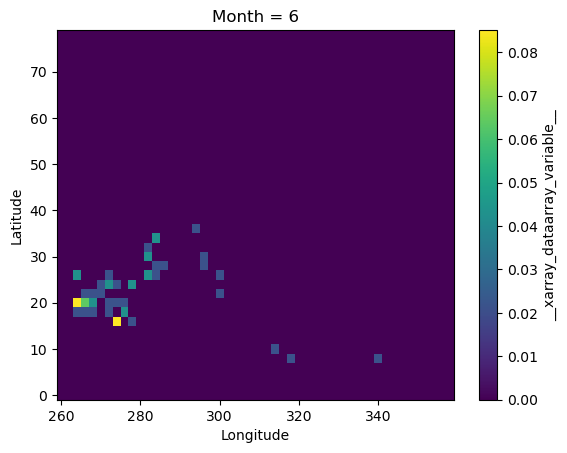

In [96]:
Gauss_SmoothAN.isel(Month=0).plot()

In [ ]:
Gauss_SmoothAN

In [ ]:
num_yrs = len(data.grid.groupby('time.year').sum('time').year.values)

sum_tors = data.grid.groupby('time.dayofyear').sum('time')

three_sum_tors = xr.concat([sum_tors,sum_tors,sum_tors], dim='dayofyear')

Gauss_SmoothAN = three_sum_tors/num_yrs

In [41]:
train_labels_predropped_read.isel(
    Year=0).isel(Month=2)['__xarray_dataarray_variable__'].astype(float)

<xarray.DataArray '__xarray_dataarray_variable__' (Latitude: 40, Longitude: 50)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * Longitude  (Longitude) int32 260 262 264 266 268 270 ... 350 352 354 356 358
    Year       int32 1950
  * Latitude   (Latitude) int32 0 2 4 6 8 10 12 14 ... 64 66 68 70 72 74 76 78
    Month      int32 8

In [42]:
gaussian_filter(train_labels_predropped_read.isel(
    Year=0).isel(Month=2)['__xarray_dataarray_variable__'].astype(float), sigma=0.2).max()

0.9999888201654741

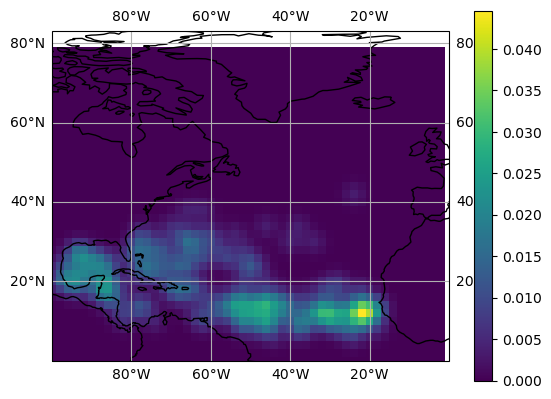

In [13]:
climo_month_label = train_labels_predropped_read.sel(Month=9).to_array()[0]
climo_mean_month_label = climo_month_label.mean('Year',skipna=True)
climo_filtered_month = gaussian_filter(climo_mean_month_label, sigma=1)
climo_filtered_month_with_coords = xr.DataArray(
    climo_filtered_month, coords=[climo_mean_month_label.coords['Latitude'],climo_mean_month_label.coords['Longitude']])

# Monthly Climatological Plot (Monthly Mean Performed)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
climo_filtered_month_plot = ax.pcolormesh(
    climo_filtered_month_with_coords.coords['Longitude'],
    climo_filtered_month_with_coords.coords['Latitude'],
    climo_filtered_month_with_coords,transform=ccrs.PlateCarree(),vmin=0)
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(climo_filtered_month_plot)
#plt.savefig('climo')
plt.show()

In [5]:
interval = 1 # pooling size (1 is no pooling)

trainlabelpoints_pooled = xr.DataArray(
    skimage.measure.block_reduce(train_labels_predropped_read.to_array()[0], (1,interval,interval,1),np.nansum),
             coords=[train_labels_predropped_read.coords['Month'],
                     train_labels_predropped_read.coords['Latitude'][::interval],
                    train_labels_predropped_read.coords['Longitude'][::interval],
                     train_labels_predropped_read.coords['Year']])

viewfilt = gaussian_filter(trainlabelpoints_pooled.sel(Month=9,Year=2000),sigma=15)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
contourplot = ax.pcolormesh(train_labels_predropped_read.coords['Longitude'][::interval],
                           train_labels_predropped_read.coords['Latitude'][::interval],viewfilt,transform=ccrs.PlateCarree())
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(contourplot)
plt.savefig('test')
# testlabelpoints_pooled_masked = testlabelpoints_pooled.where(isnan_pool != 0)

NameError: name 'skimage' is not defined

In [525]:
viewfilt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

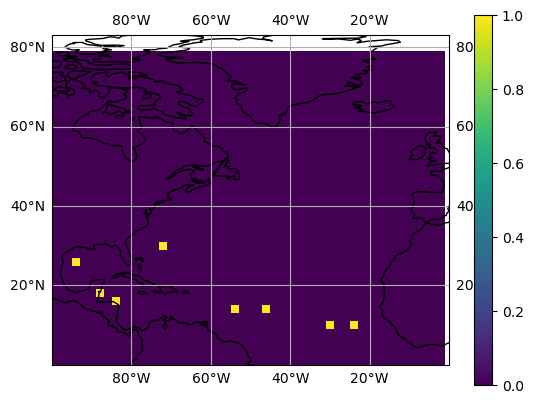

In [8]:
ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.set_global()
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_extent([-100, 0, 0, 80])
verifyplot = ax2.pcolormesh(
    train_labels_predropped_read.coords['Longitude'],
    train_labels_predropped_read.coords['Latitude'],
    train_labels_predropped_read.sel(Month=9,Year=2000).to_array()[0],transform=ccrs.PlateCarree())
cbar = plt.colorbar(verifyplot)
plt.show()

In [9]:
train_labels_predropped_read

<xarray.Dataset>
Dimensions:                        (Longitude: 50, Year: 47, Latitude: 40, Month: 6)
Coordinates:
  * Longitude                      (Longitude) int32 260 262 264 ... 354 356 358
  * Year                           (Year) int32 1950 1951 1952 ... 2003 2004
  * Latitude                       (Latitude) int32 0 2 4 6 8 ... 70 72 74 76 78
  * Month                          (Month) int32 6 7 8 9 10 11
Data variables:
    __xarray_dataarray_variable__  (Month, Latitude, Longitude, Year) int32 0...

In [428]:
train_labels_predropped_read.sel(Month=9,Year=2000).to_array()[0]

<xarray.DataArray (Latitude: 40, Longitude: 50)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * Longitude  (Longitude) int32 260 262 264 266 268 270 ... 350 352 354 356 358
    Year       int32 2000
  * Latitude   (Latitude) int32 0 2 4 6 8 10 12 14 ... 64 66 68 70 72 74 76 78
    Month      int32 9
    variable   <U29 '__xarray_dataarray_variable__'

In [404]:
contourplot.get_paths

AttributeError: 'QuadContourSet' object has no attribute 'get_paths'

In [306]:
contourplot.get_transform

<bound method ContourSet.get_transform of <matplotlib.contour.QuadContourSet object at 0x2ad67ee31de0>>